In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import (
    Normal, 
    Bernoulli, 
    kl_divergence,
)
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm



# Load MNIST
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
# X = X.astype(np.float32) / 255.0  # Normalize to [0, 1]
X = (X > 0).astype(np.float32)

# Split into train/test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_test))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")



Loading MNIST...
Train samples: 60000, Test samples: 10000


In [63]:

from deep_genomics.models import BinaryVariationalAutoencoder
from deep_genomics.training import train_binary_vae

# Training function
device = "mps"
input_dim = train_dataset[0][0].shape[0]
hidden_dims = [512,256,128]
latent_dim = 24
model = BinaryVariationalAutoencoder(
    input_dim=input_dim, 
    hidden_dims=hidden_dims, 
    latent_dim=latent_dim).to(device)


history = train_binary_vae(model, train_loader, 20, learning_rate=1e-3, beta=1, device=device)


Epoch 1/20: 100%|██████████| 118/118 [00:01<00:00, 73.73it/s]
2025-11-21 12:17:08.683 | INFO     | deep_genomics.training:train_binary_vae:308 - Epoch 1/20 - Loss: 251.9525, Recon: 249.7288, KL: 2.2237
Epoch 2/20: 100%|██████████| 118/118 [00:01<00:00, 75.95it/s]
2025-11-21 12:17:10.238 | INFO     | deep_genomics.training:train_binary_vae:308 - Epoch 2/20 - Loss: 209.0895, Recon: 203.8913, KL: 5.1982
Epoch 3/20: 100%|██████████| 118/118 [00:01<00:00, 73.53it/s]
2025-11-21 12:17:11.844 | INFO     | deep_genomics.training:train_binary_vae:308 - Epoch 3/20 - Loss: 176.6652, Recon: 167.4541, KL: 9.2111
Epoch 4/20: 100%|██████████| 118/118 [00:01<00:00, 73.89it/s]
2025-11-21 12:17:13.442 | INFO     | deep_genomics.training:train_binary_vae:308 - Epoch 4/20 - Loss: 149.0957, Recon: 136.6445, KL: 12.4512
Epoch 5/20: 100%|██████████| 118/118 [00:01<00:00, 74.89it/s]
2025-11-21 12:17:15.019 | INFO     | deep_genomics.training:train_binary_vae:308 - Epoch 5/20 - Loss: 136.3291, Recon: 123.9182, 

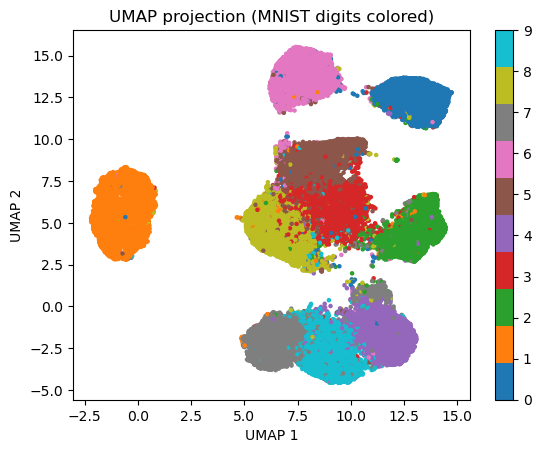

In [91]:
X_latent = model.transform(torch.from_numpy(X_train).to(device)).cpu().numpy()

import umap
import matplotlib.pyplot as plt

# Convert tensor to numpy array

# Run UMAP to reduce to 2D
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X_latent)

# Ensure labels are integers for coloring
labels = y_train.astype(int)

# Plot with digit colors
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=5)
plt.title('UMAP projection (MNIST digits colored)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

In [ ]:
y_train
# array(['5', '0', '4', ..., '5', '6', '8'], shape=(60000,), dtype=object)

array(['5', '0', '4', ..., '5', '6', '8'], shape=(60000,), dtype=object)

In [60]:
x = train_dataset[0][0].to(device)
x_transform = model.transform(x)
x_recon = model.reconstruct(x)
# ((model.reconstruct(x) > 0.5).type(torch.float32) == x).type(torch.float32).mean()


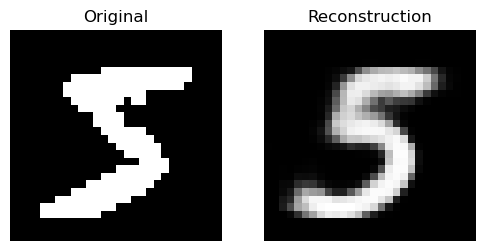

In [61]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(x.cpu().reshape(28, 28), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(x_recon.cpu().reshape(28, 28), cmap='gray')
axes[1].set_title('Reconstruction')
axes[1].axis('off')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    # Get a single sample
    x = train_dataset[0][0].unsqueeze(0).to(device)  # Shape: [1, 784]
    
    # Encode: get posterior mean (deterministic latent representation)
    mu, logvar = model.encode(x)
    
    # Decode: get logits
    logits = model.decode(mu)
    
    # Get reconstruction mean (expected pixel values)
    x_recon = torch.sigmoid(logits)
    
    # # Visualize
    # fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    # axes[0].imshow(x.cpu().reshape(28, 28), cmap='gray')
    # axes[0].set_title('Original')
    # axes[0].axis('off')
    
    # axes[1].imshow(x_recon.cpu().reshape(28, 28), cmap='gray')
    # axes[1].set_title('Reconstruction')
    # axes[1].axis('off')
    # plt.show()


    

In [31]:
x_pred = (x_recon > 0.5).cpu().numpy().astype(int)
x_ = x.cpu().numpy().astype(int)
np.mean(x_ == x_pred), x_.sum(), x_pred.sum()

(np.float64(0.96298010180472), np.int64(410), np.int64(408))

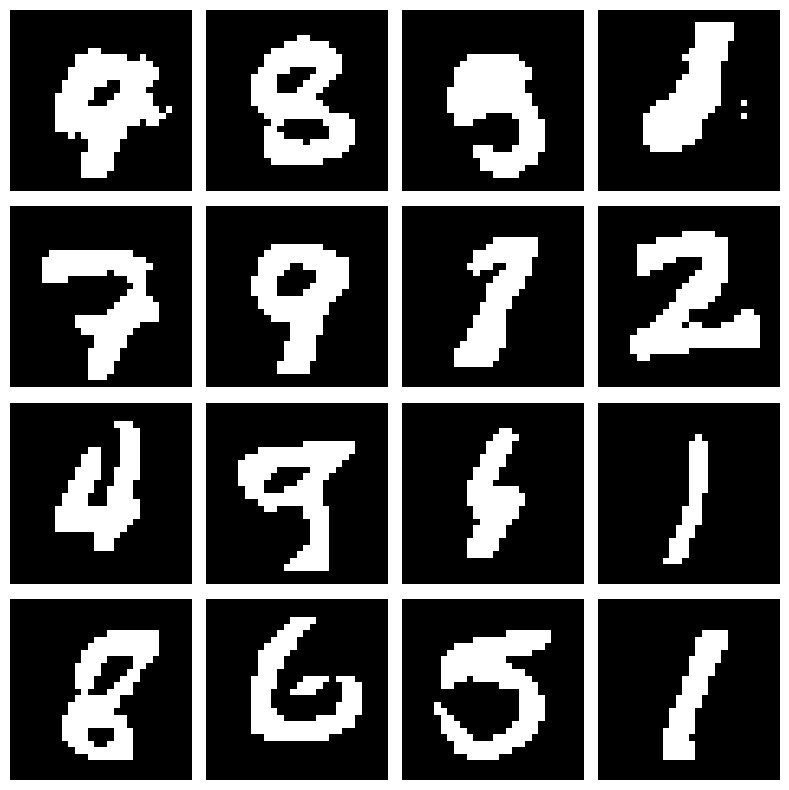

In [64]:
# Sampling
model.eval()
with torch.no_grad():
    # Sample random latent vectors from standard normal
    n_samples = 16
    z = torch.randn(n_samples, model.decoder[0].in_features).to(device)

    # Decode to get reconstructions
    logits = model.decode(z)
    samples = torch.sigmoid(logits) > 0.5
    
    # Visualize
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].cpu().reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [27]:
# def train_epoch(model, loader, optimizer, beta=1.0):
#     model.train()
#     total_loss = 0
#     for batch in loader:
#         x = batch[0].to(device)
        
#         optimizer.zero_grad()
#         p_x, q_z, z = model(x)
#         loss, recon, kl = vae_loss(x, p_x, q_z, beta)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     return total_loss / len(loader)

# # Train
# num_epochs = 10
# for epoch in range(num_epochs):
#     loss = train_epoch(model, train_loader, optimizer, beta=1.0)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# # Generate samples
# model.eval()
# with torch.no_grad():
#     z = torch.randn(16, 20).to(device)
#     logits = model.decode(z)
#     samples = torch.sigmoid(logits).cpu().numpy()
    
#     fig, axes = plt.subplots(4, 4, figsize=(8, 8))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(samples[i].reshape(28, 28), cmap='gray')
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

In [54]:
11 % 5

1